In [2]:
import pandas as pd

# Загрузка данных
df = pd.read_csv('cleaned_comments.csv', delimiter='\t', header=0)

# Удаление колонок Unnamed
df.drop(columns=[col for col in df.columns if col.startswith('Unnamed')], inplace=True)

# Создание нового столбца для комментариев
df['comment'] = ''

# Перебор всех строк для перемещения комментариев
for idx, row in df.iterrows():
    # Поиск первого непустого строкового значения в строке
    comment = next((v for v in row if isinstance(v, str) and v.strip()), '')
    
    # Запись комментария в новый столбец
    df.at[idx, 'comment'] = comment
    
    # Обнуление исходных столбцов и установка флагов
    for col in df.columns[:-1]:  # Все столбцы кроме нового 'comment'
        df.at[idx, col] = 1 if str(row[col]).strip() == comment.strip() else 0

# Сохранение результата
df.to_csv('processed_comments.csv', index=False)

╒════════════════════════════════╕
│ Обнаруженные столбцы в файле:  │
╘════════════════════════════════╛
['Вопрос решен', 'Вопрос не решен ', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки', 'comment'] 



Прогресс обработки:   0%|          | 0/1735 [00:00<?, ?it/s]

Прогресс обработки:   0%|          | 0/1735 [00:00<?, ?it/s]

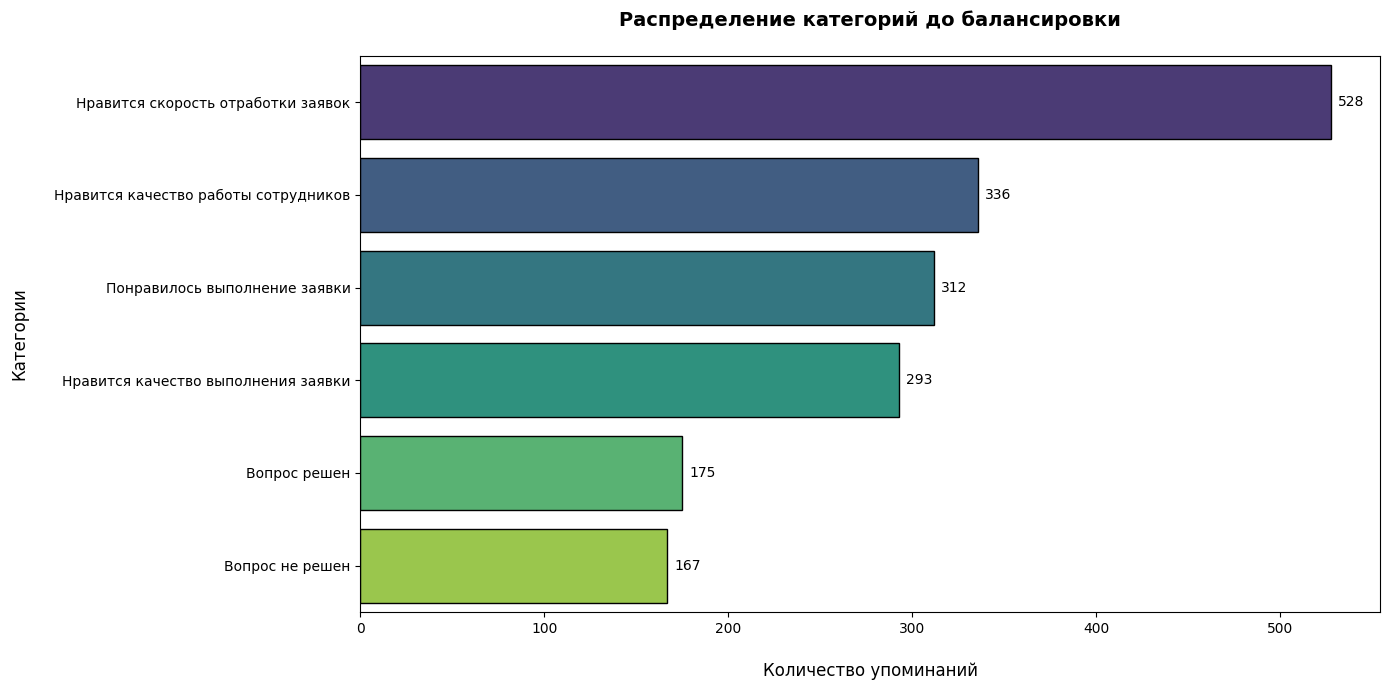

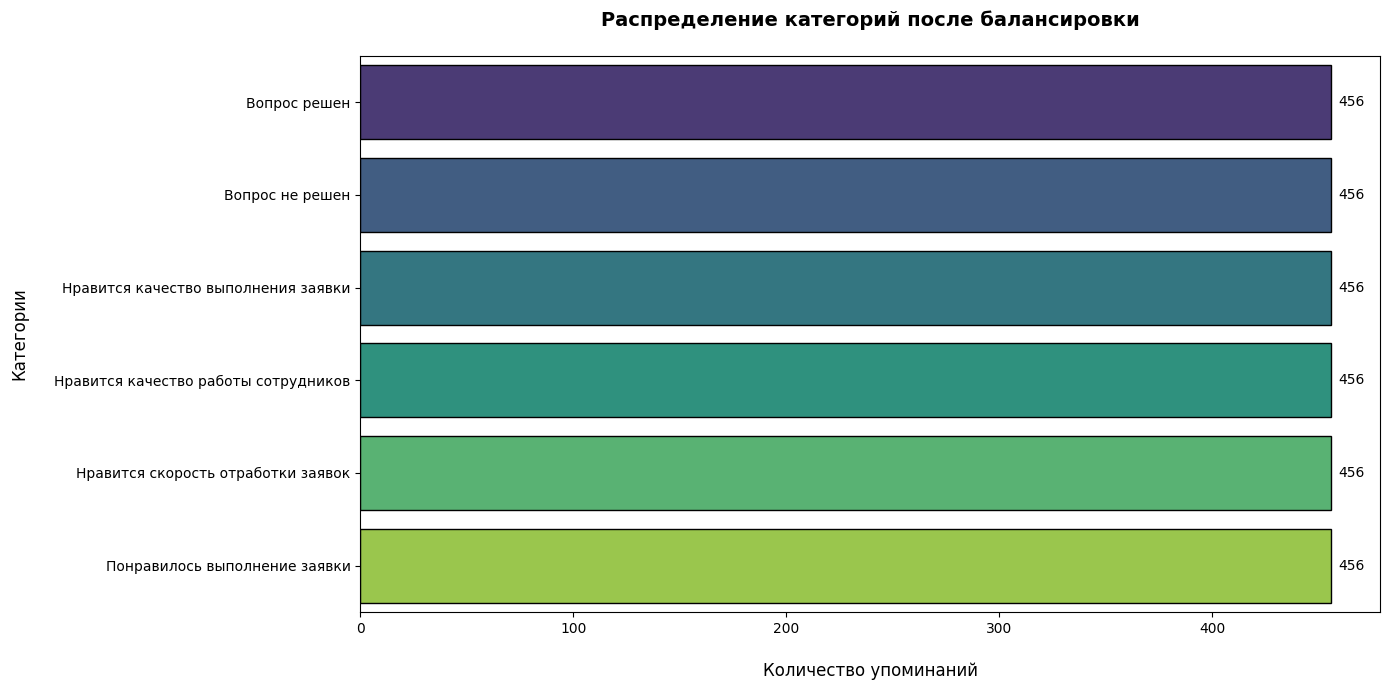

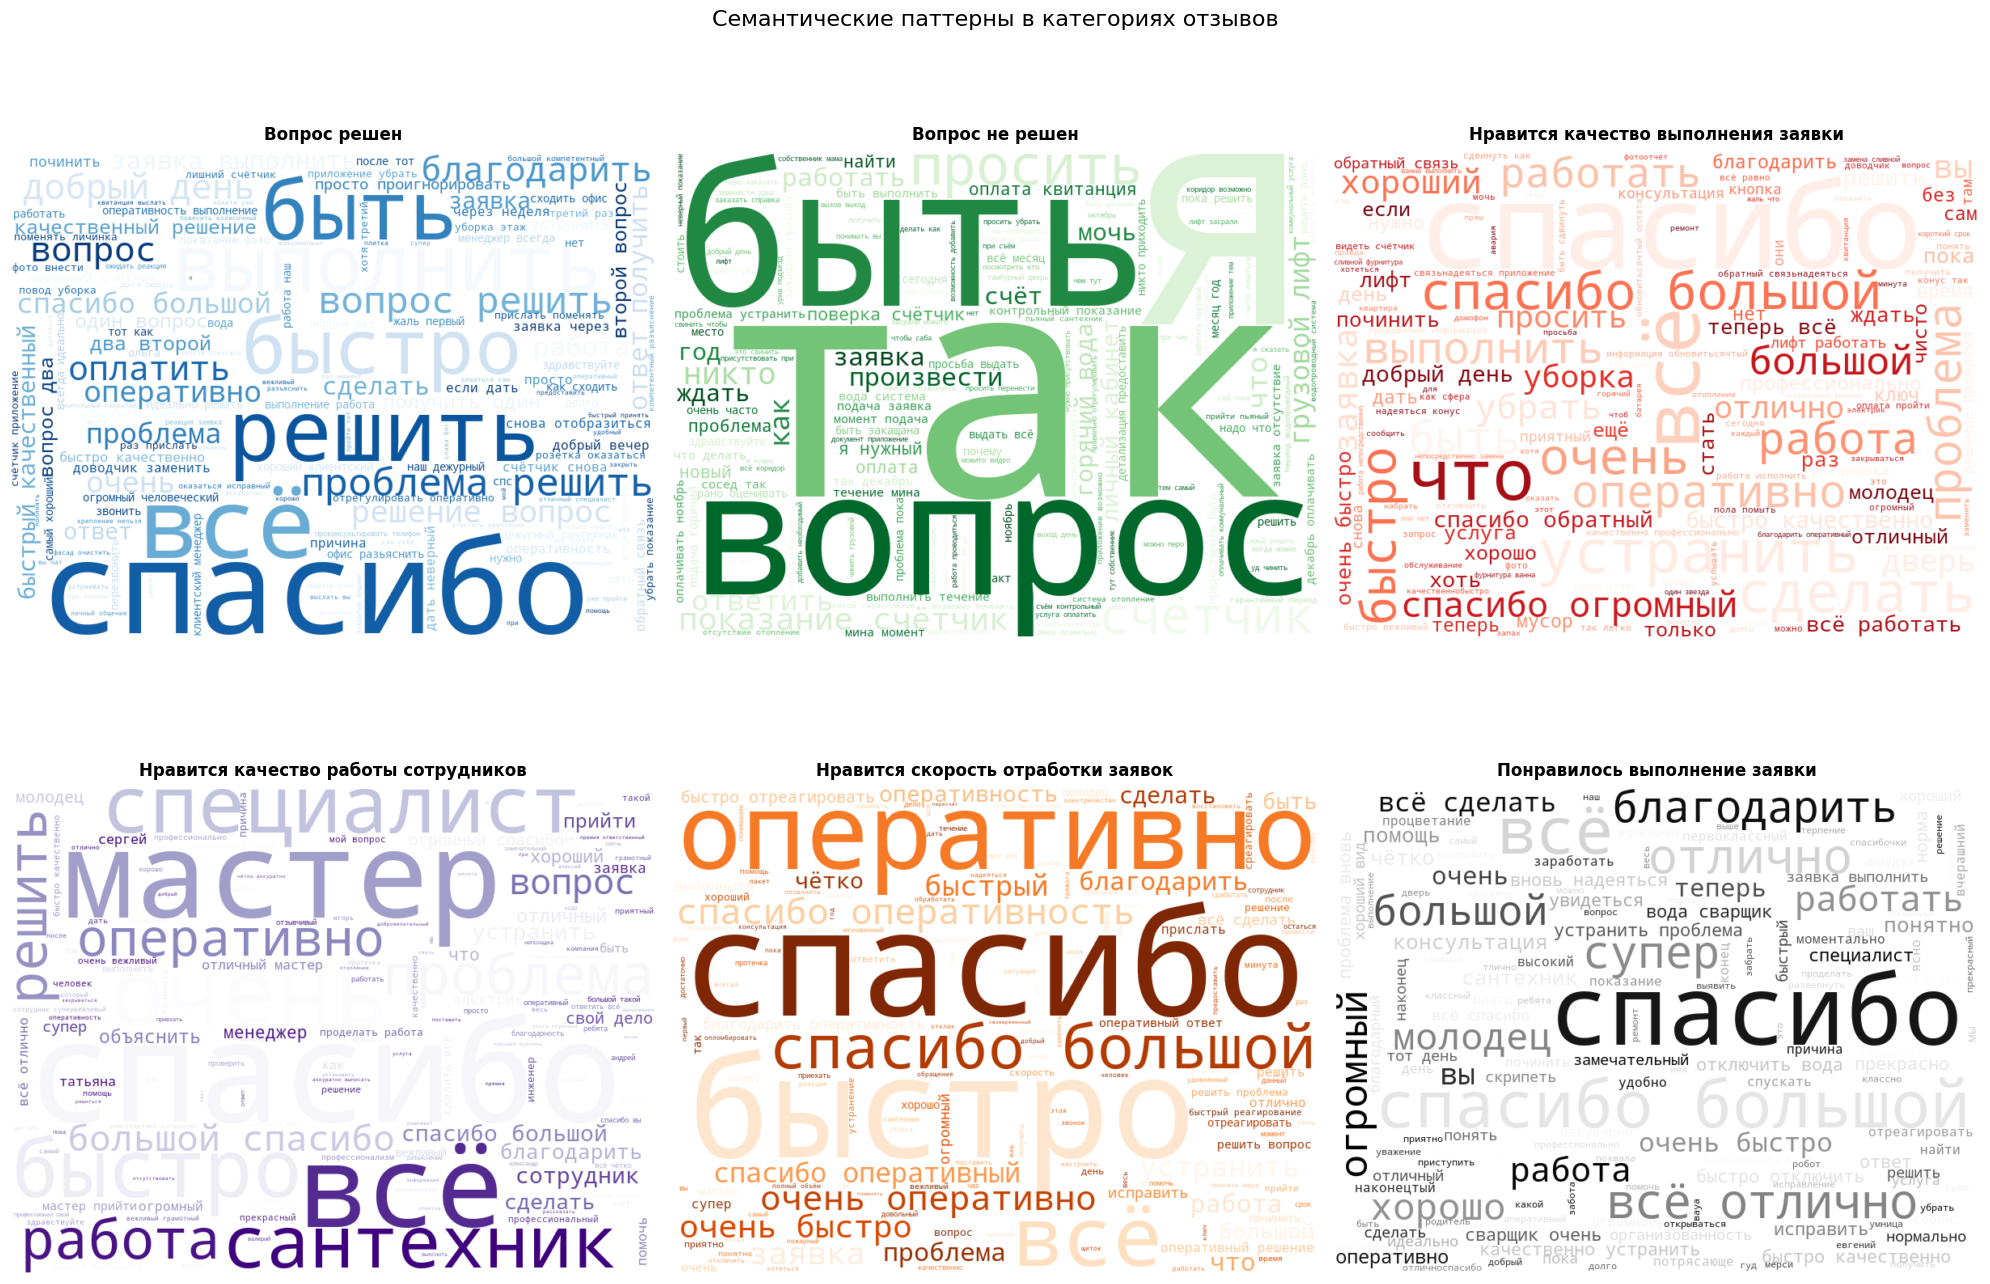


✅ Данные успешно сохранены в processed_data_final1.csv


In [3]:
import pandas as pd
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pymorphy3 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from tqdm.auto import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

# 1. Инициализация инструментов
morph = MorphAnalyzer()
tqdm.pandas(desc="Прогресс обработки")

# Конфигурация обработки
CONFIG = {
    "random_state": 42,
    "max_features": 500,
    "ngram_range": (1, 2),
    "min_samples": 10,
    "text_columns": {
        'Вопрос решен': ['вопрос решен', 'решен', 'решено', 'статус решен'],
        'Вопрос не решен': ['вопрос не решен', 'вопрос не решен ', 'не решен', 'не решено'],
        'Нравится качество выполнения заявки': ['нравится качество выполнения заявки', 'качество выполнения'],
        'Нравится качество работы сотрудников': ['нравится качество работы сотрудников', 'качество работы'],
        'Нравится скорость отработки заявок': ['нравится скорость отработки заявок', 'скорость обработки'],
        'Понравилось выполнение заявки': ['понравилось выполнение заявки', 'общая оценка'],
        'comment': ['comment', 'текст отзыва', 'отзыв', 'текст']
    }
}

# 2. Улучшенная загрузка и нормализация данных
def load_and_prepare_data(file_path):
    try:
        df = pd.read_csv(file_path, sep=',', encoding='utf-8')
        print("╒════════════════════════════════╕")
        print("│ Обнаруженные столбцы в файле:  │")
        print("╘════════════════════════════════╛")
        print(df.columns.tolist(), '\n')
        
        column_mapping = {}
        for target, variants in CONFIG['text_columns'].items():
            found = None
            for col in df.columns:
                # Нормализация названий
                norm_col = re.sub(r'\s+', ' ', col).strip().lower()
                norm_variants = [re.sub(r'\s+', ' ', v).strip().lower() for v in variants]
                
                if norm_col in norm_variants:
                    found = col
                    break
                    
            if not found:
                available = [f"'{v}'" for v in df.columns]
                raise KeyError(f"Столбец '{target}' не найден. Доступные столбцы: {', '.join(available)}")
            
            column_mapping[found] = target
        
        return df.rename(columns=column_mapping)
    
    except Exception as e:
        print(f"⛔ Критическая ошибка загрузки: {str(e)}")
        exit()

# 3. Улучшенная предобработка текста
class TextPreprocessor:
    def __init__(self, morph):
        self.morph = morph
        self.regex = {
            'clean': re.compile(r'[^а-яё\s]'),
            'spaces': re.compile(r'\s+')
        }
    
    def preprocess(self, text):
        text = str(text).lower()
        text = self.regex['clean'].sub('', text)
        text = self.regex['spaces'].sub(' ', text).strip()
        return text
    
    def lemmatize(self, text):
        words = text.split()
        return ' '.join([
            self.morph.parse(word)[0].normal_form 
            for word in words 
            if len(word) > 2  # Убрана проверка на стоп-слова
        ])

# 4. Балансировка данных с улучшенной обработкой
def balance_dataset(df, categories):
    df = df.copy()
    
    # Обработка мультиметок
    df['multi_label'] = df[categories].sum(axis=1)
    df = df[df['multi_label'] <= 1]
    
    # Разделение данных
    labeled = df[df['multi_label'] == 1].copy()
    unlabeled = df[df['multi_label'] == 0].copy()
    
    if not labeled.empty:
        try:
            # Проверка минимального количества образцов
            class_counts = labeled[categories].sum()
            if (class_counts < CONFIG['min_samples']).any():
                raise ValueError(f"Слишком мало образцов: {class_counts[class_counts < CONFIG['min_samples']]}")
            
            # Балансировка
            labeled['label'] = labeled[categories].idxmax(axis=1)
            ros = RandomOverSampler(random_state=CONFIG['random_state'])
            
            X_res, y_res = ros.fit_resample(
                labeled[['lemmatized', 'text_length']],
                labeled['label']
            )
            
            # Восстановление данных
            df_resampled = pd.DataFrame(X_res, columns=['lemmatized', 'text_length'])
            df_resampled['label'] = y_res
            
            # Восстановление всех столбцов
            for cat in categories:
                df_resampled[cat] = (df_resampled['label'] == cat).astype(int)
            
            return pd.concat([df_resampled.drop('label', axis=1), unlabeled], axis=0)
            
        except Exception as e:
            print(f"⚠️ Ошибка балансировки: {str(e)}")
            return pd.concat([labeled, unlabeled], axis=0)
    
    return df

# 5. Главный процесс обработки
def main():
    # Загрузка данных
    df = load_and_prepare_data('processed_comments.csv')
    
    # Предобработка текста
    preprocessor = TextPreprocessor(morph)
    df['cleaned'] = df['comment'].progress_apply(preprocessor.preprocess)
    df['lemmatized'] = df['cleaned'].progress_apply(preprocessor.lemmatize)
    df['text_length'] = df['lemmatized'].apply(lambda x: len(x.split()))
    
    # Визуализация исходного распределения
    categories = list(CONFIG['text_columns'].keys())[:-1]
    plot_distribution(df, categories, 'Распределение категорий до балансировки')
    
    # Балансировка
    df_balanced = balance_dataset(df, categories)
    
    # Визуализация после балансировки
    plot_distribution(df_balanced, categories, 'Распределение категорий после балансировки')
    
    # Векторизация
    tfidf = TfidfVectorizer(
        ngram_range=CONFIG['ngram_range'],
        max_features=CONFIG['max_features'],
        token_pattern=r'(?u)\b[а-яё]{3,}\b'
    )
    
    tfidf_matrix = tfidf.fit_transform(df_balanced['lemmatized'])
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=[f"tfidf_{re.sub(r'[^a-z0-9]', '_', col)}" for col in tfidf.get_feature_names_out()]
    )
    
    # Финализация данных
    final_df = pd.concat([df_balanced.reset_index(drop=True), tfidf_df], axis=1)
    
    # Генерация облака слов
    generate_wordclouds(final_df, categories)
    
    # Сохранение
    output_columns = categories + ['lemmatized', 'text_length'] + list(tfidf_df.columns)
    final_df[output_columns].to_csv('processed_data_final1.csv', index=False)
    print("\n✅ Данные успешно сохранены в processed_data_final1.csv")

# 6. Улучшенные функции визуализации
def plot_distribution(df, categories, title):
    plt.figure(figsize=(14, 7))
    distribution = df[categories].sum().sort_values(ascending=False)
    
    ax = sns.barplot(
        x=distribution.values,
        y=distribution.index,
        palette="viridis",
        edgecolor='black'
    )
    
    plt.title(f'{title}\n', fontsize=14, fontweight='bold')
    plt.xlabel('\nКоличество упоминаний', fontsize=12)
    plt.ylabel('Категории\n', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_width()):,}", 
            (p.get_width(), p.get_y() + p.get_height()/2),
            ha='left', va='center',
            fontsize=10,
            color='black',
            xytext=(5, 0),
            textcoords='offset points'
        )
    
    plt.tight_layout()
    plt.show()

def generate_wordclouds(df, categories):
    plt.figure(figsize=(20, 15))
    colors = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'Greys']
    
    for i, (col, color) in enumerate(zip(categories, colors), 1):
        try:
            text = ' '.join(df[df[col] == 1]['lemmatized'])
            if not text:
                raise ValueError("Нет данных для визуализации")
                
            wordcloud = WordCloud(
                width=800,
                height=600,
                background_color='white',
                colormap=color,
                max_words=150,
                contour_width=1,
                contour_color='steelblue'
            ).generate(text)
            
            plt.subplot(2, 3, i)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(col, fontsize=12, pad=10, fontweight='bold')
            plt.axis('off')
            
        except Exception as e:
            print(f"⚠️ Ошибка в категории {col}: {str(e)}")
            plt.subplot(2, 3, i)
            plt.text(0.5, 0.5, 'Данные отсутствуют', ha='center', va='center')
            plt.axis('off')
    
    plt.suptitle('Семантические паттерны в категориях отзывов\n', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


🔍 Анализ топ-20 значимых слов по категориям...


Обработка категорий:   0%|          | 0/6 [00:00<?, ?it/s]

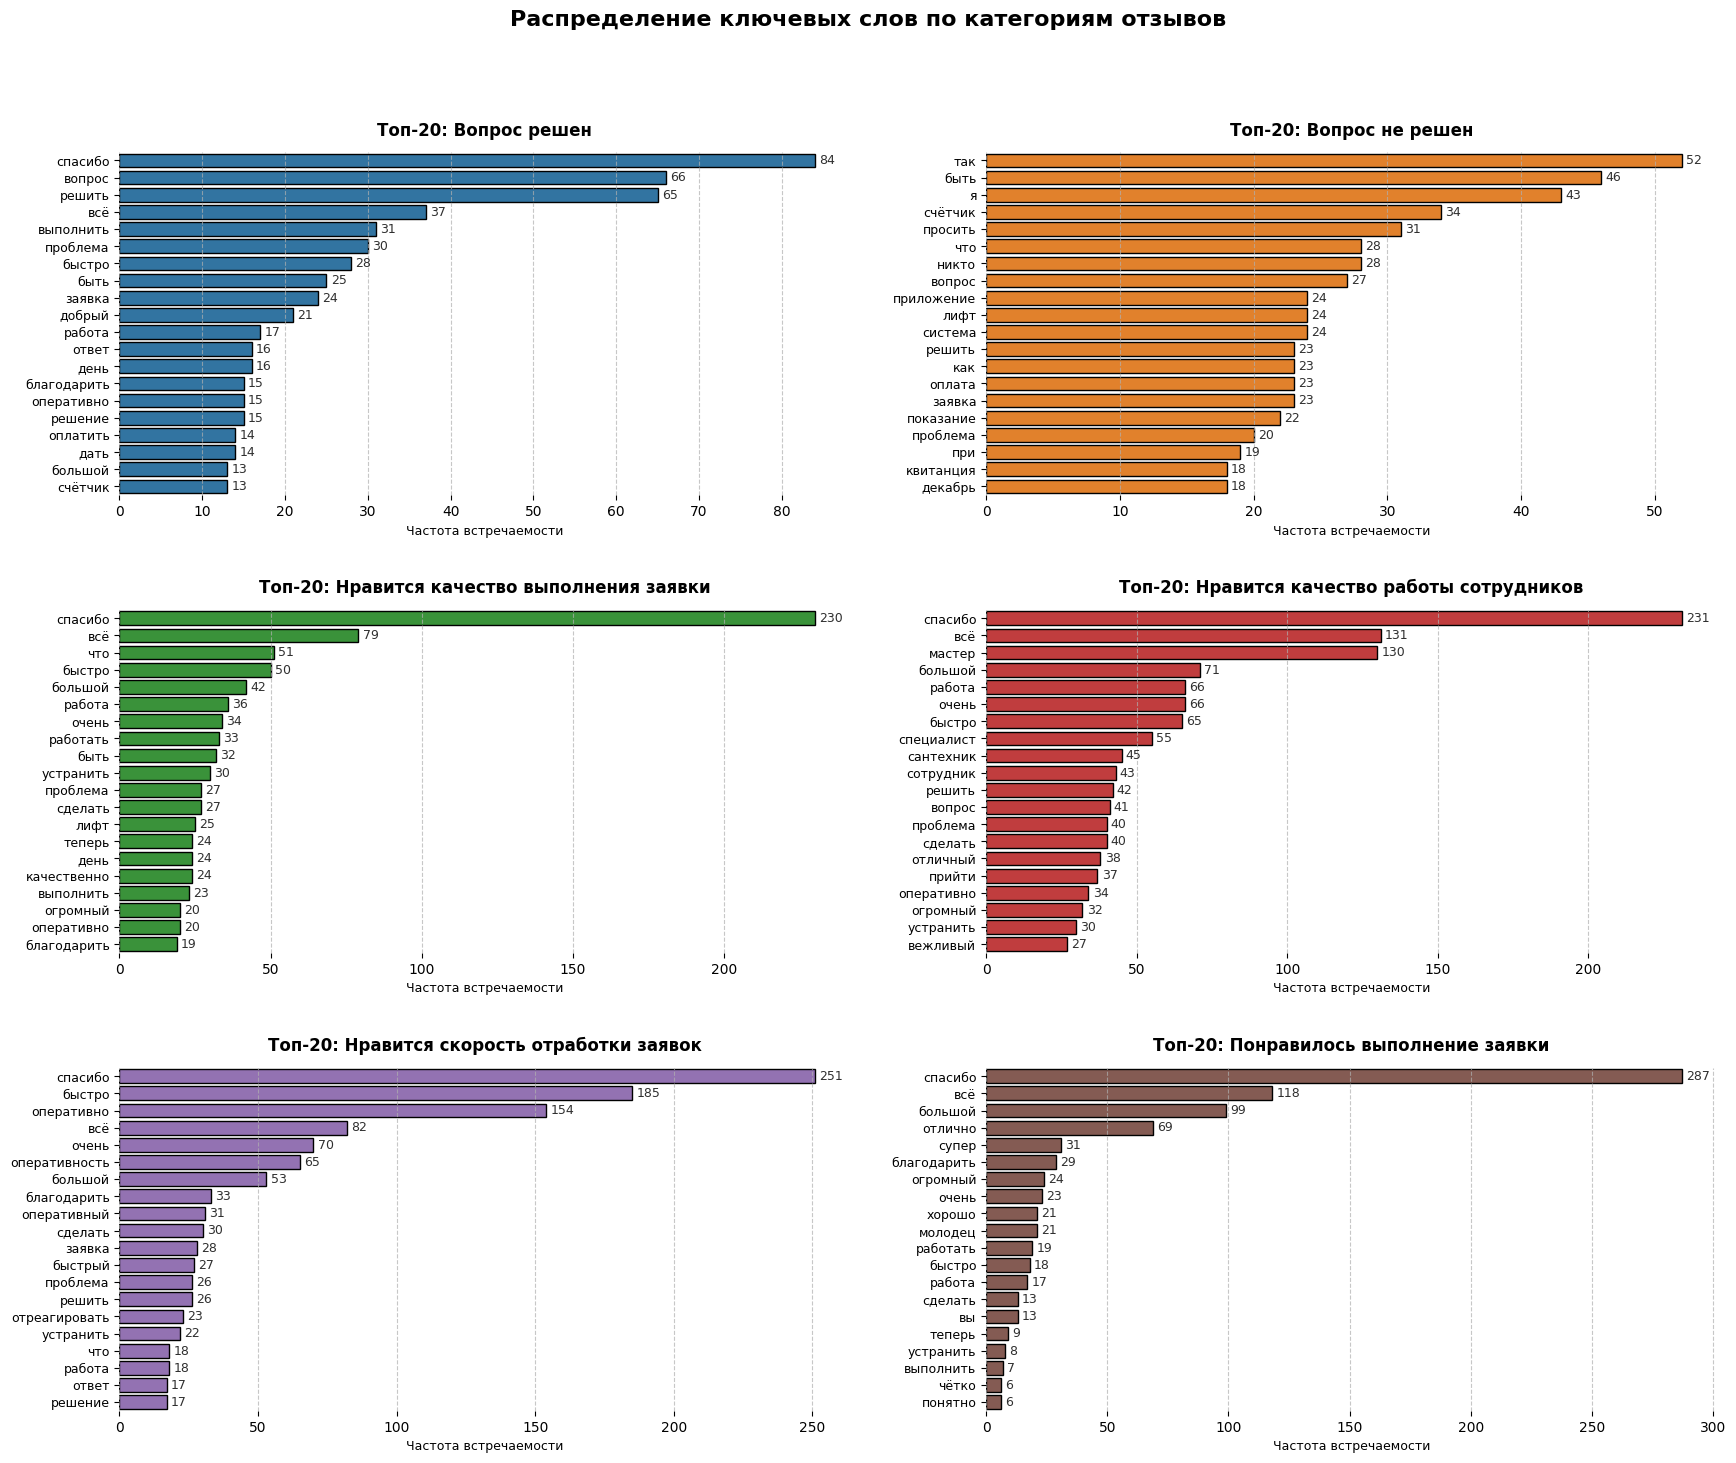

In [4]:
# top_words_analysis.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm

def load_processed_data(file_path='processed_data_final1.csv'):
    """Загрузка предобработанных данных"""
    try:
        df = pd.read_csv(file_path)
        required_columns = ['Вопрос решен', 'Вопрос не решен', 
                           'Нравится качество выполнения заявки', 
                           'Нравится качество работы сотрудников',
                           'Нравится скорость отработки заявок',
                           'Понравилось выполнение заявки', 'lemmatized']
        
        if not all(col in df.columns for col in required_columns):
            missing = [col for col in required_columns if col not in df.columns]
            raise ValueError(f"Отсутствуют необходимые колонки: {missing}")
            
        return df
    
    except Exception as e:
        print(f"Ошибка загрузки данных: {str(e)}")
        exit()

def analyze_top_words(df):
    """Анализ и визуализация топ-20 слов по категориям"""
    print("\n🔍 Анализ топ-20 значимых слов по категориям...")
    
    categories = [
        'Вопрос решен',
        'Вопрос не решен',
        'Нравится качество выполнения заявки',
        'Нравится качество работы сотрудников',
        'Нравится скорость отработки заявок',
        'Понравилось выполнение заявки'
    ]
    
    # Настройка визуализации
    plt.figure(figsize=(18, 15))
    palettes = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Прогресс-бар
    pbar = tqdm(zip(categories, palettes), total=len(categories), desc="Обработка категорий")
    
    for i, (category, color) in enumerate(pbar, 1):
        ax = plt.subplot(3, 2, i)
        try:
            # Фильтрация и подготовка данных
            category_data = df[df[category] == 1]
            if len(category_data) == 0:
                raise ValueError("Нет данных для анализа")
                
            texts = category_data['lemmatized'].fillna('').astype(str)
            
            # Подсчет слов
            word_counts = Counter(" ".join(texts).split())
            top_words = word_counts.most_common(20)
            
            # Создание DataFrame для визуализации
            words_df = pd.DataFrame(top_words, columns=['word', 'count'])
            
            # Построение графика
            sns.barplot(x='count', y='word', data=words_df, 
                        ax=ax, color=color, edgecolor='black')
            
            # Аннотации
            ax.bar_label(ax.containers[0], fmt='%d', 
                        padding=3, fontsize=9, color='#2f2f2f')
            
            # Оформление
            ax.set_title(f'Топ-20: {category}', fontsize=12, pad=12, fontweight='bold')
            ax.set_xlabel('Частота встречаемости', fontsize=9)
            ax.set_ylabel('')
            ax.tick_params(axis='y', labelsize=9)
            ax.grid(axis='x', linestyle='--', alpha=0.7)
            
            # Удаление рамок
            for spine in ax.spines.values():
                spine.set_visible(False)
                
        except Exception as e:
            print(f"\n⚠️ Ошибка в категории {category}: {str(e)}")
            ax.set_visible(False)
            continue

    plt.suptitle('Распределение ключевых слов по категориям отзывов\n', 
                fontsize=16, y=0.99, fontweight='bold')
    plt.tight_layout(pad=3.0)
    plt.show()

if __name__ == "__main__":
    data = load_processed_data()
    analyze_top_words(data)


Найдена текстовая колонка: 'lemmatized'


Обработка текста:   0%|          | 0/2737 [00:00<?, ?it/s]


Успешно обработано 2737 записей

Обучение модели...

Кросс-валидация...


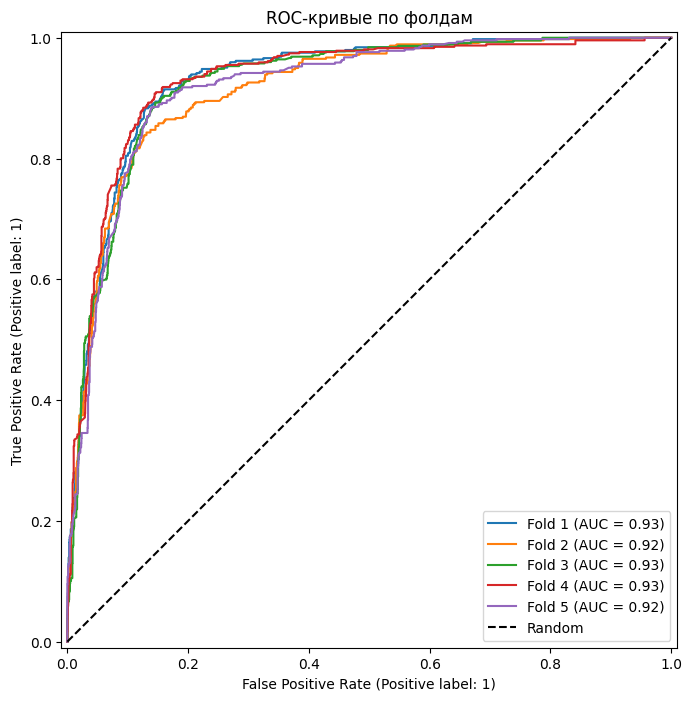


Результаты валидации:
Средний AUC: 0.911
Нравится качество выполнения заявки: 0.746 ± 0.016
Нравится качество работы сотрудников: 0.950 ± 0.010
Нравится скорость отработки заявок: 0.963 ± 0.015
Вопрос решен: 0.911 ± 0.026
Вопрос не решен: 0.987 ± 0.001

Тестовые предсказания:

Отзыв 1:
Текст: Быстро и качественно выполнили работу
Категории:
  Вопрос решен: 0.663
Макс. вероятность: 0.663

Отзыв 2:
Текст: Пришлось ждать три дня, результат плохой
Категории:
  Вопрос не решен: 0.595
Макс. вероятность: 0.595

Отзыв 3:
Текст: 
Категории: не определены
Макс. вероятность: 0.000

Отзыв 4:
Текст: Сотрудник опоздал, но проблему решил
Категории:
  Нравится качество работы сотрудников: 0.830
Макс. вероятность: 0.830

Отзыв 5:
Текст: Никто не приехал, обслуживание ужасное
Категории:
  Вопрос не решен: 0.872
Макс. вероятность: 0.872

Отзыв 6:
Текст: Сотрудники работают оперативно, заявка выполнена в срок.
Категории:
  Нравится скорость отработки заявок: 0.592
Макс. вероятность: 0.592

Отзыв 7:
Текст

In [5]:
# наш выбор

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline
from pymorphy2 import MorphAnalyzer
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Инициализация инструментов для препроцессинга
morph = MorphAnalyzer()

# 1. Функции препроцессинга текста (удалена фильтрация стоп-слов)
def preprocess_text(text):
    text = str(text).lower()
    
    # Обработка отрицаний
    text = re.sub(r'\bне\s+(\w+)', r'не_\1', text)
    
    # Лемматизация без стоп-слов
    words = []
    for word in re.findall(r'\b[\w-]+\b', text):
        p = morph.parse(word)[0]
        words.append(p.normal_form)
    
    return ' '.join(words)

# 2. Загрузка и подготовка данных
def load_and_prepare_data(file_path='processed_data_final1.csv'):
    try:
        # Попытка чтения с разными кодировками
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='cp1251')

        # Автопоиск текстовой колонки
        text_columns = []
        for col in df.columns:
            if df[col].dtype == 'object' and df[col].str.len().mean() > 20:
                text_columns.append(col)
        
        if not text_columns:
            available_cols = "\n".join(df.columns)
            raise ValueError(
                f"Текстовые колонки не найдены. Доступные колонки:\n{available_cols}"
            )
            
        text_column = text_columns[0]
        print(f"\nНайдена текстовая колонка: '{text_column}'")
        
        # Препроцессинг текста с прогресс-баром
        tqdm.pandas(desc="Обработка текста")
        df['processed_text'] = df[text_column].progress_apply(preprocess_text)
        
        # Определение категорий
        category_candidates = [
            'Нравится качество выполнения заявки',
            'Нравится качество работы сотрудников',
            'Нравится скорость отработки заявок',
            'Вопрос решен',
            'Вопрос не решен'
        ]
        categories = [c for c in category_candidates if c in df.columns]
        
        if not categories:
            raise ValueError("Целевые категории не найдены в данных")
        
        # Фильтрация данных
        df = df.dropna(subset=categories)
        print(f"\nУспешно обработано {len(df)} записей")
        
        return df['processed_text'].values, df[categories].values, categories
    
    except Exception as e:
        print(f"\nОшибка при загрузке данных: {str(e)}")
        raise

# 3. Пайплайн модели (удалены стоп-слова из векторизатора)
def build_model():
    return make_pipeline(
        TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.85
        ),
        ADASYN(random_state=42, sampling_strategy='not majority'),
        OneVsRestClassifier(
            LogisticRegression(
                C=0.9,
                solver='saga',
                max_iter=1000,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            )
        )
    )

# 4. Кросс-валидация
def cross_validate(X, y, categories, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {
        'auc_scores': [],
        'category_auc': {c: [] for c in categories}
    }
    
    plt.figure(figsize=(10, 8))
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y.argmax(1))):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = build_model()
        model.fit(X_train, y_train)
        
        y_proba = model.predict_proba(X_test)
        
        # Расчет метрик
        fold_auc = roc_auc_score(y_test, y_proba, average='macro')
        results['auc_scores'].append(fold_auc)
        
        for i, cat in enumerate(categories):
            if y_test[:,i].sum() > 0:
                results['category_auc'][cat].append(
                    roc_auc_score(y_test[:,i], y_proba[:,i])
                )
        
        # Визуализация ROC
        RocCurveDisplay.from_predictions(
            LabelBinarizer().fit_transform(y_test).ravel(),
            y_proba.ravel(),
            name=f"Fold {fold+1}",
            ax=plt.gca()
        )
    
    plt.plot([0,1], [0,1], 'k--', label="Random")
    plt.title('ROC-кривые по фолдам')
    plt.legend()
    plt.show()
    
    return results

# 5. Генерация предсказаний
def predict_with_threshold(model, texts, categories, threshold=0.25):
    processed = [preprocess_text(t) if t.strip() else '' for t in texts]
    probas = model.predict_proba(processed)
    
    predictions = []
    for text, proba in zip(texts, probas):
        prediction = {
            'text': text,
            'categories': [],
            'probabilities': {},
            'max_score': 0.0
        }
        
        if not text.strip():
            predictions.append(prediction)
            continue
        
        max_score = np.max(proba)
        selected = [(cat, score) for cat, score in zip(categories, proba) if score >= max(threshold, max_score)]
        
        prediction['categories'] = [cat for cat, _ in selected]
        prediction['probabilities'] = {cat: float(score) for cat, score in zip(categories, proba)}
        prediction['max_score'] = float(max_score)
        
        predictions.append(prediction)
    
    return predictions

# Главная функция
def main():
    try:
        X, y, cats = load_and_prepare_data()
        
        print("\nОбучение модели...")
        model = build_model()
        model.fit(X, y)
        
        print("\nКросс-валидация...")
        cv_results = cross_validate(X, y, cats)
        
        print("\nРезультаты валидации:")
        print(f"Средний AUC: {np.mean(cv_results['auc_scores']):.3f}")
        for cat in cats:
            scores = cv_results['category_auc'][cat]
            if scores:
                print(f"{cat}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

        test_texts = [
            "Быстро и качественно выполнили работу",
            "Пришлось ждать три дня, результат плохой",
            "",
            "Сотрудник опоздал, но проблему решил",
            "Никто не приехал, обслуживание ужасное",
            # Новые комментарии
            "Сотрудники работают оперативно, заявка выполнена в срок.",
            "Качество услуг на высоте, но пришлось долго ждать ответа.",
            "Проблема осталась нерешенной, очень разочарован.",
            "Быстро приехали и все починили, молодцы!",
            "Сотрудник был вежлив, но решение заняло много времени.",
            "Заявку выполнили некачественно, пришлось переделывать.",
            "Никакой обратной связи, вопрос так и висит.",
            "Молниеносная реакция и профессиональный подход!",
            "Работа сделана хорошо, но сотрудник опоздал на встречу.",
            "До сих пор нет ответа, прошло уже три дня."
        ]
        
        print("\nТестовые предсказания:")
        predictions = predict_with_threshold(model, test_texts, cats, 0.25)
        
        for i, pred in enumerate(predictions):
            print(f"\nОтзыв {i+1}:")
            print(f"Текст: {pred['text']}")
            if pred['categories']:
                print("Категории:")
                for cat in pred['categories']:
                    print(f"  {cat}: {pred['probabilities'][cat]:.3f}")
            else:
                print("Категории: не определены")
            print(f"Макс. вероятность: {pred['max_score']:.3f}")
            
    except Exception as e:
        print(f"\nКритическая ошибка: {str(e)}")

if __name__ == "__main__":
    main()


Найдена текстовая колонка: 'lemmatized'


Обработка текста:   0%|          | 0/2737 [00:00<?, ?it/s]


Успешно обработано 2737 записей

Обучение модели...

Кросс-валидация...


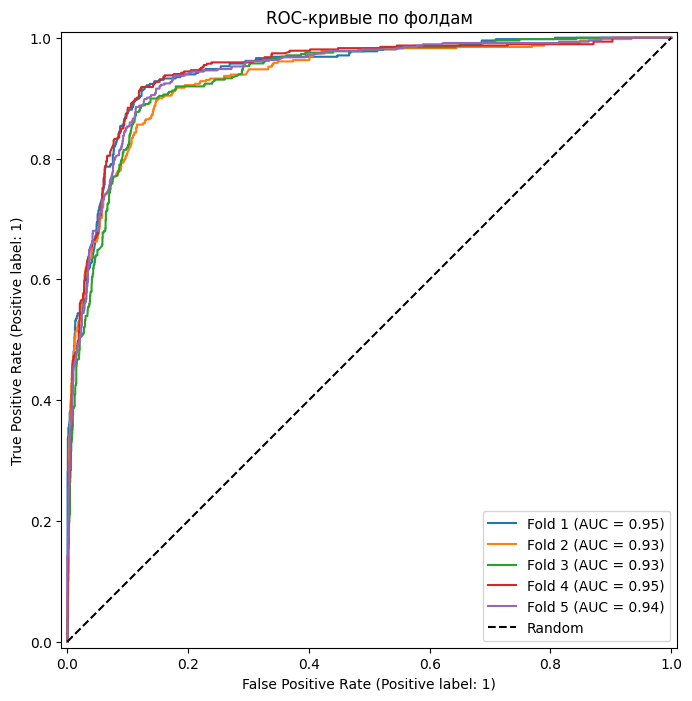


Результаты валидации:
Средний AUC: 0.925
Нравится качество выполнения заявки: 0.794 ± 0.029
Нравится качество работы сотрудников: 0.951 ± 0.009
Нравится скорость отработки заявок: 0.959 ± 0.013
Вопрос решен: 0.933 ± 0.022
Вопрос не решен: 0.988 ± 0.004

Тестовые предсказания:

Отзыв 1:
Текст: Быстро и качественно выполнили работу
Категории:
  Нравится качество выполнения заявки: 0.400
Макс. вероятность: 0.400

Отзыв 2:
Текст: Пришлось ждать три дня, результат плохой
Категории: не определены
Макс. вероятность: 0.146

Отзыв 3:
Текст: 
Категории: не определены
Макс. вероятность: 0.000

Отзыв 4:
Текст: Сотрудник опоздал, но проблему решил
Категории:
  Нравится качество работы сотрудников: 0.768
Макс. вероятность: 0.768

Отзыв 5:
Текст: Никто не приехал, обслуживание ужасное
Категории:
  Вопрос не решен: 0.936
Макс. вероятность: 0.936

Отзыв 6:
Текст: Сотрудники работают оперативно, заявка выполнена в срок.
Категории: не определены
Макс. вероятность: 0.111

Отзыв 7:
Текст: Качество услуг н

In [6]:
# наш выбор

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline
from pymorphy2 import MorphAnalyzer
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Инициализация инструментов для препроцессинга
morph = MorphAnalyzer()

# 1. Функции препроцессинга текста (удалена фильтрация стоп-слов)
def preprocess_text(text):
    text = str(text).lower()
    
    # Обработка отрицаний
    text = re.sub(r'\bне\s+(\w+)', r'не_\1', text)
    
    # Лемматизация без стоп-слов
    words = []
    for word in re.findall(r'\b[\w-]+\b', text):
        p = morph.parse(word)[0]
        words.append(p.normal_form)
    
    return ' '.join(words)

# 2. Загрузка и подготовка данных
def load_and_prepare_data(file_path='processed_data_final1.csv'):
    try:
        # Попытка чтения с разными кодировками
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='cp1251')

        # Автопоиск текстовой колонки
        text_columns = []
        for col in df.columns:
            if df[col].dtype == 'object' and df[col].str.len().mean() > 20:
                text_columns.append(col)
        
        if not text_columns:
            available_cols = "\n".join(df.columns)
            raise ValueError(
                f"Текстовые колонки не найдены. Доступные колонки:\n{available_cols}"
            )
            
        text_column = text_columns[0]
        print(f"\nНайдена текстовая колонка: '{text_column}'")
        
        # Препроцессинг текста с прогресс-баром
        tqdm.pandas(desc="Обработка текста")
        df['processed_text'] = df[text_column].progress_apply(preprocess_text)
        
        # Определение категорий
        category_candidates = [
            'Нравится качество выполнения заявки',
            'Нравится качество работы сотрудников',
            'Нравится скорость отработки заявок',
            'Вопрос решен',
            'Вопрос не решен'
        ]
        categories = [c for c in category_candidates if c in df.columns]
        
        if not categories:
            raise ValueError("Целевые категории не найдены в данных")
        
        # Фильтрация данных
        df = df.dropna(subset=categories)
        print(f"\nУспешно обработано {len(df)} записей")
        
        return df['processed_text'].values, df[categories].values, categories
    
    except Exception as e:
        print(f"\nОшибка при загрузке данных: {str(e)}")
        raise

# 3. Пайплайн модели (обновлено для SVM)
def build_model():
    return make_pipeline(
        TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.85
        ),
        ADASYN(random_state=42, sampling_strategy='not majority'),
        OneVsRestClassifier(
            CalibratedClassifierCV(
                LinearSVC(
                    C=0.9,
                    class_weight='balanced',
                    max_iter=10000,
                    random_state=42,
                    penalty='l2',
                    loss='squared_hinge'
                )
            )
        )
    )

# 4. Кросс-валидация
def cross_validate(X, y, categories, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {
        'auc_scores': [],
        'category_auc': {c: [] for c in categories}
    }
    
    plt.figure(figsize=(10, 8))
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y.argmax(1))):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = build_model()
        model.fit(X_train, y_train)
        
        y_proba = model.predict_proba(X_test)
        
        # Расчет метрик
        fold_auc = roc_auc_score(y_test, y_proba, average='macro')
        results['auc_scores'].append(fold_auc)
        
        for i, cat in enumerate(categories):
            if y_test[:,i].sum() > 0:
                results['category_auc'][cat].append(
                    roc_auc_score(y_test[:,i], y_proba[:,i])
                )
        
        # Визуализация ROC
        RocCurveDisplay.from_predictions(
            LabelBinarizer().fit_transform(y_test).ravel(),
            y_proba.ravel(),
            name=f"Fold {fold+1}",
            ax=plt.gca()
        )
    
    plt.plot([0,1], [0,1], 'k--', label="Random")
    plt.title('ROC-кривые по фолдам')
    plt.legend()
    plt.show()
    
    return results

# 5. Генерация предсказаний
def predict_with_threshold(model, texts, categories, threshold=0.25):
    processed = [preprocess_text(t) if t.strip() else '' for t in texts]
    probas = model.predict_proba(processed)
    
    predictions = []
    for text, proba in zip(texts, probas):
        prediction = {
            'text': text,
            'categories': [],
            'probabilities': {},
            'max_score': 0.0
        }
        
        if not text.strip():
            predictions.append(prediction)
            continue
        
        max_score = np.max(proba)
        selected = [(cat, score) for cat, score in zip(categories, proba) if score >= max(threshold, max_score)]
        
        prediction['categories'] = [cat for cat, _ in selected]
        prediction['probabilities'] = {cat: float(score) for cat, score in zip(categories, proba)}
        prediction['max_score'] = float(max_score)
        
        predictions.append(prediction)
    
    return predictions

# Главная функция
def main():
    try:
        X, y, cats = load_and_prepare_data()
        
        print("\nОбучение модели...")
        model = build_model()
        model.fit(X, y)
        
        print("\nКросс-валидация...")
        cv_results = cross_validate(X, y, cats)
        
        print("\nРезультаты валидации:")
        print(f"Средний AUC: {np.mean(cv_results['auc_scores']):.3f}")
        for cat in cats:
            scores = cv_results['category_auc'][cat]
            if scores:
                print(f"{cat}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

        test_texts = [
            "Быстро и качественно выполнили работу",
            "Пришлось ждать три дня, результат плохой",
            "",
            "Сотрудник опоздал, но проблему решил",
            "Никто не приехал, обслуживание ужасное",
            # Новые комментарии
            "Сотрудники работают оперативно, заявка выполнена в срок.",
            "Качество услуг на высоте, но пришлось долго ждать ответа.",
            "Проблема осталась нерешенной, очень разочарован.",
            "Быстро приехали и все починили, молодцы!",
            "Сотрудник был вежлив, но решение заняло много времени.",
            "Заявку выполнили некачественно, пришлось переделывать.",
            "Никакой обратной связи, вопрос так и висит.",
            "Молниеносная реакция и профессиональный подход!",
            "Работа сделана хорошо, но сотрудник опоздал на встречу.",
            "До сих пор нет ответа, прошло уже три дня."
        ]
        
        print("\nТестовые предсказания:")
        predictions = predict_with_threshold(model, test_texts, cats, 0.25)
        
        for i, pred in enumerate(predictions):
            print(f"\nОтзыв {i+1}:")
            print(f"Текст: {pred['text']}")
            if pred['categories']:
                print("Категории:")
                for cat in pred['categories']:
                    print(f"  {cat}: {pred['probabilities'][cat]:.3f}")
            else:
                print("Категории: не определены")
            print(f"Макс. вероятность: {pred['max_score']:.3f}")
            
    except Exception as e:
        print(f"\nКритическая ошибка: {str(e)}")

if __name__ == "__main__":
    main()


Найдена текстовая колонка: 'lemmatized'


Обработка текста:   0%|          | 0/2737 [00:00<?, ?it/s]


Успешно обработано 2737 записей

Обучение модели...

Кросс-валидация...


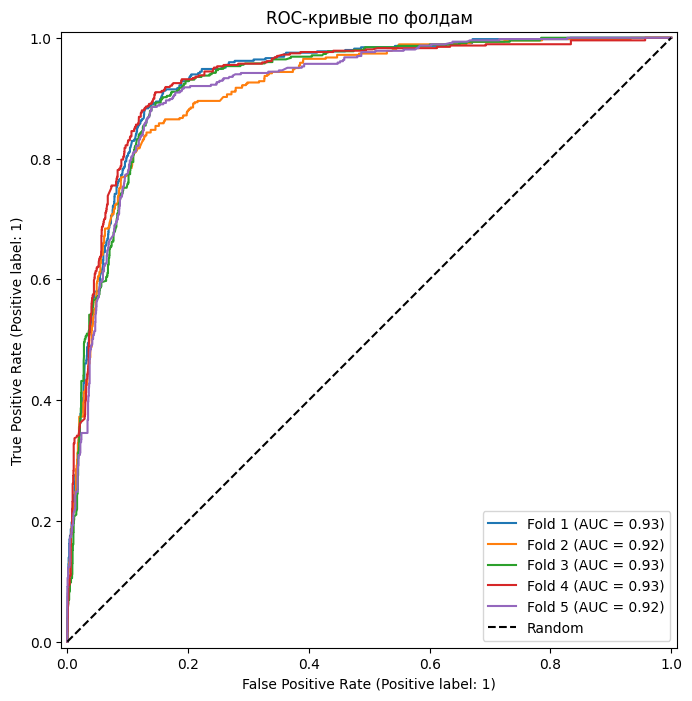


Результаты валидации:
Средний AUC: 0.911
Нравится качество выполнения заявки: 0.745 ± 0.016
Нравится качество работы сотрудников: 0.950 ± 0.010
Нравится скорость отработки заявок: 0.963 ± 0.015
Вопрос решен: 0.911 ± 0.026
Вопрос не решен: 0.987 ± 0.001

Тестовые предсказания:

Отзыв 1:
Текст: Быстро и качественно выполнили работу
Категории:
  Вопрос решен: 0.656
Макс. вероятность: 0.656

Отзыв 2:
Текст: Пришлось ждать три дня, результат плохой
Категории:
  Вопрос не решен: 0.592
Макс. вероятность: 0.592

Отзыв 3:
Текст: 
Категории: не определены
Макс. вероятность: 0.000

Отзыв 4:
Текст: Сотрудник опоздал, но проблему решил
Категории:
  Нравится качество работы сотрудников: 0.830
Макс. вероятность: 0.830

Отзыв 5:
Текст: Никто не приехал, обслуживание ужасное
Категории:
  Вопрос не решен: 0.873
Макс. вероятность: 0.873

Отзыв 6:
Текст: Сотрудники работают оперативно, заявка выполнена в срок.
Категории:
  Нравится скорость отработки заявок: 0.594
Макс. вероятность: 0.594

Отзыв 7:
Текст

In [7]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline
from pymorphy2 import MorphAnalyzer
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Инициализация инструментов для препроцессинга
morph = MorphAnalyzer()

# 1. Функции препроцессинга текста (удалена фильтрация стоп-слов)
def preprocess_text(text):
    text = str(text).lower()
    
    # Обработка отрицаний
    text = re.sub(r'\bне\s+(\w+)', r'не_\1', text)
    
    # Лемматизация без стоп-слов
    words = []
    for word in re.findall(r'\b[\w-]+\b', text):
        p = morph.parse(word)[0]
        words.append(p.normal_form)
    
    return ' '.join(words)

# 2. Загрузка и подготовка данных
def load_and_prepare_data(file_path='processed_data_final1.csv'):
    try:
        # Попытка чтения с разными кодировками
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='cp1251')

        # Автопоиск текстовой колонки
        text_columns = []
        for col in df.columns:
            if df[col].dtype == 'object' and df[col].str.len().mean() > 20:
                text_columns.append(col)
        
        if not text_columns:
            available_cols = "\n".join(df.columns)
            raise ValueError(
                f"Текстовые колонки не найдены. Доступные колонки:\n{available_cols}"
            )
            
        text_column = text_columns[0]
        print(f"\nНайдена текстовая колонка: '{text_column}'")
        
        # Препроцессинг текста с прогресс-баром
        tqdm.pandas(desc="Обработка текста")
        df['processed_text'] = df[text_column].progress_apply(preprocess_text)
        
        # Определение категорий
        category_candidates = [
            'Нравится качество выполнения заявки',
            'Нравится качество работы сотрудников',
            'Нравится скорость отработки заявок',
            'Вопрос решен',
            'Вопрос не решен'
        ]
        categories = [c for c in category_candidates if c in df.columns]
        
        if not categories:
            raise ValueError("Целевые категории не найдены в данных")
        
        # Фильтрация данных
        df = df.dropna(subset=categories)
        print(f"\nУспешно обработано {len(df)} записей")
        
        return df['processed_text'].values, df[categories].values, categories
    
    except Exception as e:
        print(f"\nОшибка при загрузке данных: {str(e)}")
        raise

# 3. Пайплайн модели (обновлено для Logistic Regression)
def build_model():
    return make_pipeline(
        TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.85
        ),
        ADASYN(random_state=42, sampling_strategy='not majority'),
        OneVsRestClassifier(
            LogisticRegression(
                C=0.9,
                class_weight='balanced',
                max_iter=10000,
                random_state=42,
                penalty='l2',
                solver='lbfgs',
                n_jobs=-1
            )
        )
    )

# 4. Кросс-валидация
def cross_validate(X, y, categories, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {
        'auc_scores': [],
        'category_auc': {c: [] for c in categories}
    }
    
    plt.figure(figsize=(10, 8))
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y.argmax(1))):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = build_model()
        model.fit(X_train, y_train)
        
        y_proba = model.predict_proba(X_test)
        
        # Расчет метрик
        fold_auc = roc_auc_score(y_test, y_proba, average='macro')
        results['auc_scores'].append(fold_auc)
        
        for i, cat in enumerate(categories):
            if y_test[:,i].sum() > 0:
                results['category_auc'][cat].append(
                    roc_auc_score(y_test[:,i], y_proba[:,i]))
        
        # Визуализация ROC
        RocCurveDisplay.from_predictions(
            LabelBinarizer().fit_transform(y_test).ravel(),
            y_proba.ravel(),
            name=f"Fold {fold+1}",
            ax=plt.gca()
        )
    
    plt.plot([0,1], [0,1], 'k--', label="Random")
    plt.title('ROC-кривые по фолдам')
    plt.legend()
    plt.show()
    
    return results

# 5. Генерация предсказаний
def predict_with_threshold(model, texts, categories, threshold=0.25):
    processed = [preprocess_text(t) if t.strip() else '' for t in texts]
    probas = model.predict_proba(processed)
    
    predictions = []
    for text, proba in zip(texts, probas):
        prediction = {
            'text': text,
            'categories': [],
            'probabilities': {},
            'max_score': 0.0
        }
        
        if not text.strip():
            predictions.append(prediction)
            continue
        
        max_score = np.max(proba)
        selected = [(cat, score) for cat, score in zip(categories, proba) if score >= max(threshold, max_score)]
        
        prediction['categories'] = [cat for cat, _ in selected]
        prediction['probabilities'] = {cat: float(score) for cat, score in zip(categories, proba)}
        prediction['max_score'] = float(max_score)
        
        predictions.append(prediction)
    
    return predictions

# Главная функция
def main():
    try:
        X, y, cats = load_and_prepare_data()
        
        print("\nОбучение модели...")
        model = build_model()
        model.fit(X, y)
        
        print("\nКросс-валидация...")
        cv_results = cross_validate(X, y, cats)
        
        print("\nРезультаты валидации:")
        print(f"Средний AUC: {np.mean(cv_results['auc_scores']):.3f}")
        for cat in cats:
            scores = cv_results['category_auc'][cat]
            if scores:
                print(f"{cat}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

        test_texts = [
            "Быстро и качественно выполнили работу",
            "Пришлось ждать три дня, результат плохой",
            "",
            "Сотрудник опоздал, но проблему решил",
            "Никто не приехал, обслуживание ужасное",
            "Сотрудники работают оперативно, заявка выполнена в срок.",
            "Качество услуг на высоте, но пришлось долго ждать ответа.",
            "Проблема осталась нерешенной, очень разочарован.",
            "Быстро приехали и все починили, молодцы!",
            "Сотрудник был вежлив, но решение заняло много времени.",
            "Заявку выполнили некачественно, пришлось переделывать.",
            "Никакой обратной связи, вопрос так и висит.",
            "Молниеносная реакция и профессиональный подход!",
            "Работа сделана хорошо, но сотрудник опоздал на встречу.",
            "До сих пор нет ответа, прошло уже три дня."
        ]
        
        print("\nТестовые предсказания:")
        predictions = predict_with_threshold(model, test_texts, cats, 0.25)
        
        for i, pred in enumerate(predictions):
            print(f"\nОтзыв {i+1}:")
            print(f"Текст: {pred['text']}")
            if pred['categories']:
                print("Категории:")
                for cat in pred['categories']:
                    print(f"  {cat}: {pred['probabilities'][cat]:.3f}")
            else:
                print("Категории: не определены")
            print(f"Макс. вероятность: {pred['max_score']:.3f}")
            
    except Exception as e:
        print(f"\nКритическая ошибка: {str(e)}")

if __name__ == "__main__":
    main()


Найдена текстовая колонка: 'lemmatized'


Обработка текста:   0%|          | 0/2737 [00:00<?, ?it/s]


Успешно обработано 2737 записей

Обучение модели...

Кросс-валидация...


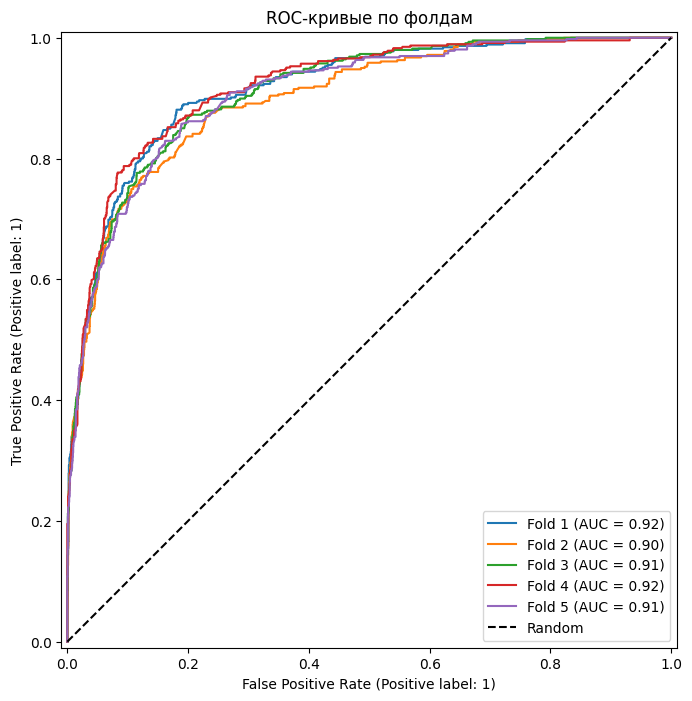


Результаты валидации:
Средний AUC: 0.902
Нравится качество выполнения заявки: 0.776 ± 0.012
Нравится качество работы сотрудников: 0.924 ± 0.007
Нравится скорость отработки заявок: 0.946 ± 0.013
Вопрос решен: 0.885 ± 0.028
Вопрос не решен: 0.981 ± 0.002

Тестовые предсказания:

Отзыв 1:
Текст: Быстро и качественно выполнили работу
Категории: не определены
Макс. вероятность: 0.208

Отзыв 2:
Текст: Пришлось ждать три дня, результат плохой
Категории:
  Вопрос не решен: 0.321
Макс. вероятность: 0.321

Отзыв 3:
Текст: 
Категории: не определены
Макс. вероятность: 0.000

Отзыв 4:
Текст: Сотрудник опоздал, но проблему решил
Категории:
  Нравится качество работы сотрудников: 0.287
Макс. вероятность: 0.287

Отзыв 5:
Текст: Никто не приехал, обслуживание ужасное
Категории:
  Вопрос не решен: 0.823
Макс. вероятность: 0.823

Отзыв 6:
Текст: Сотрудники работают оперативно, заявка выполнена в срок.
Категории: не определены
Макс. вероятность: 0.177

Отзыв 7:
Текст: Качество услуг на высоте, но пришлос

In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.naive_bayes import MultinomialNB  # Измененный импорт
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline
from pymorphy2 import MorphAnalyzer
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Инициализация инструментов для препроцессинга
morph = MorphAnalyzer()

# 1. Функции препроцессинга текста (без изменений)
def preprocess_text(text):
    text = str(text).lower()
    
    # Обработка отрицаний
    text = re.sub(r'\bне\s+(\w+)', r'не_\1', text)
    
    # Лемматизация без стоп-слов
    words = []
    for word in re.findall(r'\b[\w-]+\b', text):
        p = morph.parse(word)[0]
        words.append(p.normal_form)
    
    return ' '.join(words)

# 2. Загрузка и подготовка данных (без изменений)
def load_and_prepare_data(file_path='processed_data_final1.csv'):
    try:
        # Попытка чтения с разными кодировками
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='cp1251')

        # Автопоиск текстовой колонки
        text_columns = []
        for col in df.columns:
            if df[col].dtype == 'object' and df[col].str.len().mean() > 20:
                text_columns.append(col)
        
        if not text_columns:
            available_cols = "\n".join(df.columns)
            raise ValueError(
                f"Текстовые колонки не найдены. Доступные колонки:\n{available_cols}"
            )
            
        text_column = text_columns[0]
        print(f"\nНайдена текстовая колонка: '{text_column}'")
        
        # Препроцессинг текста с прогресс-баром
        tqdm.pandas(desc="Обработка текста")
        df['processed_text'] = df[text_column].progress_apply(preprocess_text)
        
        # Определение категорий
        category_candidates = [
            'Нравится качество выполнения заявки',
            'Нравится качество работы сотрудников',
            'Нравится скорость отработки заявок',
            'Вопрос решен',
            'Вопрос не решен'
        ]
        categories = [c for c in category_candidates if c in df.columns]
        
        if not categories:
            raise ValueError("Целевые категории не найдены в данных")
        
        # Фильтрация данных
        df = df.dropna(subset=categories)
        print(f"\nУспешно обработано {len(df)} записей")
        
        return df['processed_text'].values, df[categories].values, categories
    
    except Exception as e:
        print(f"\nОшибка при загрузке данных: {str(e)}")
        raise

# 3. Пайплайн модели (изменена только модель)
def build_model():
    return make_pipeline(
        TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.85
        ),
        ADASYN(random_state=42, sampling_strategy='not majority'),
        OneVsRestClassifier(
            MultinomialNB(alpha=0.7)  # Измененная модель
        )
    )

# 4. Кросс-валидация (без изменений)
def cross_validate(X, y, categories, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {
        'auc_scores': [],
        'category_auc': {c: [] for c in categories}
    }
    
    plt.figure(figsize=(10, 8))
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y.argmax(1))):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = build_model()
        model.fit(X_train, y_train)
        
        y_proba = model.predict_proba(X_test)
        
        # Расчет метрик
        fold_auc = roc_auc_score(y_test, y_proba, average='macro')
        results['auc_scores'].append(fold_auc)
        
        for i, cat in enumerate(categories):
            if y_test[:,i].sum() > 0:
                results['category_auc'][cat].append(
                    roc_auc_score(y_test[:,i], y_proba[:,i])
                )
        
        # Визуализация ROC
        RocCurveDisplay.from_predictions(
            LabelBinarizer().fit_transform(y_test).ravel(),
            y_proba.ravel(),
            name=f"Fold {fold+1}",
            ax=plt.gca()
        )
    
    plt.plot([0,1], [0,1], 'k--', label="Random")
    plt.title('ROC-кривые по фолдам')
    plt.legend()
    plt.show()
    
    return results

# 5. Генерация предсказаний (без изменений)
def predict_with_threshold(model, texts, categories, threshold=0.25):
    processed = [preprocess_text(t) if t.strip() else '' for t in texts]
    probas = model.predict_proba(processed)
    
    predictions = []
    for text, proba in zip(texts, probas):
        prediction = {
            'text': text,
            'categories': [],
            'probabilities': {},
            'max_score': 0.0
        }
        
        if not text.strip():
            predictions.append(prediction)
            continue
        
        max_score = np.max(proba)
        selected = [(cat, score) for cat, score in zip(categories, proba) if score >= max(threshold, max_score)]
        
        prediction['categories'] = [cat for cat, _ in selected]
        prediction['probabilities'] = {cat: float(score) for cat, score in zip(categories, proba)}
        prediction['max_score'] = float(max_score)
        
        predictions.append(prediction)
    
    return predictions

# Главная функция (без изменений)
def main():
    try:
        X, y, cats = load_and_prepare_data()
        
        print("\nОбучение модели...")
        model = build_model()
        model.fit(X, y)
        
        print("\nКросс-валидация...")
        cv_results = cross_validate(X, y, cats)
        
        print("\nРезультаты валидации:")
        print(f"Средний AUC: {np.mean(cv_results['auc_scores']):.3f}")
        for cat in cats:
            scores = cv_results['category_auc'][cat]
            if scores:
                print(f"{cat}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

        test_texts = [
            "Быстро и качественно выполнили работу",
            "Пришлось ждать три дня, результат плохой",
            "",
            "Сотрудник опоздал, но проблему решил",
            "Никто не приехал, обслуживание ужасное",
            # Новые комментарии
            "Сотрудники работают оперативно, заявка выполнена в срок.",
            "Качество услуг на высоте, но пришлось долго ждать ответа.",
            "Проблема осталась нерешенной, очень разочарован.",
            "Быстро приехали и все починили, молодцы!",
            "Сотрудник был вежлив, но решение заняло много времени.",
            "Заявку выполнили некачественно, пришлось переделывать.",
            "Никакой обратной связи, вопрос так и висит.",
            "Молниеносная реакция и профессиональный подход!",
            "Работа сделана хорошо, но сотрудник опоздал на встречу.",
            "До сих пор нет ответа, прошло уже три дня."
        ]
        
        print("\nТестовые предсказания:")
        predictions = predict_with_threshold(model, test_texts, cats, 0.25)
        
        for i, pred in enumerate(predictions):
            print(f"\nОтзыв {i+1}:")
            print(f"Текст: {pred['text']}")
            if pred['categories']:
                print("Категории:")
                for cat in pred['categories']:
                    print(f"  {cat}: {pred['probabilities'][cat]:.3f}")
            else:
                print("Категории: не определены")
            print(f"Макс. вероятность: {pred['max_score']:.3f}")
            
    except Exception as e:
        print(f"\nКритическая ошибка: {str(e)}")

if __name__ == "__main__":
    main()